 # Fruit Ripeness Detection 

### Importing required libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
TRAIN_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
VAL_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'
TEST_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

### Initializing Image Size

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

### Initializing train, validation & test data

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   target_size=(IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 5280 images belonging to 3 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VAL_PATH,
                                                             target_size=(IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 1320 images belonging to 3 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Over Ripe
1 : Ripe
2 : Unripe


### Plot Images with labels

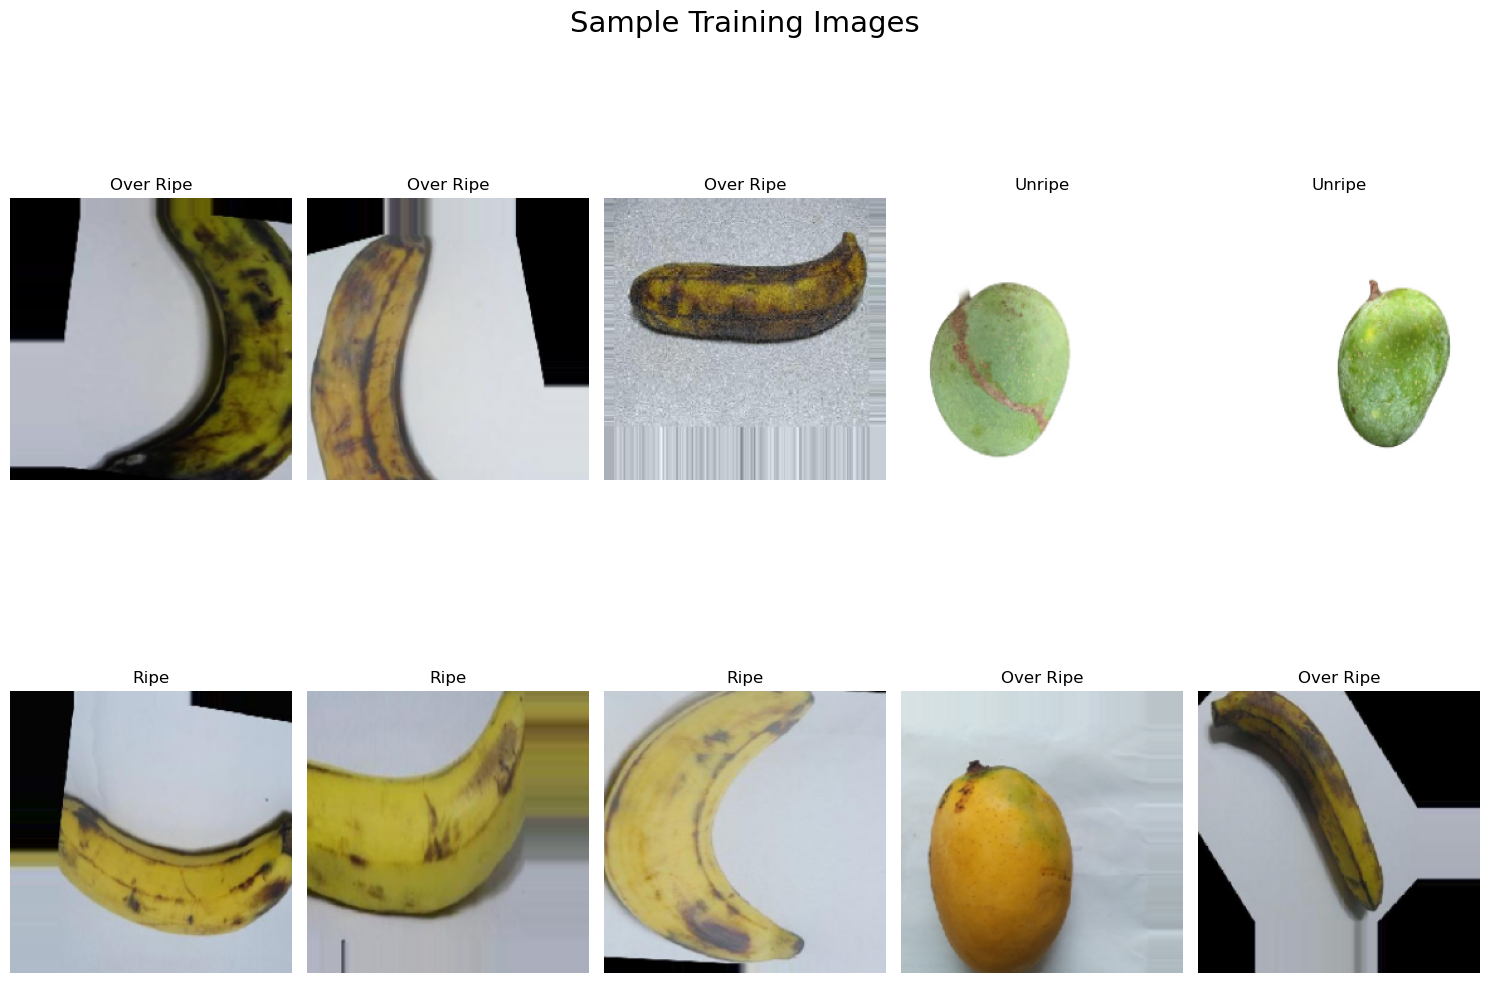

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [8]:
class_num = 3
image_w = 224
image_h = 224

### Import model for Transfer Learning

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4

inputs = layers.Input(shape=(image_w,image_h, 3))

outputs = EfficientNetB4(include_top=True, weights=None, classes=class_num)(inputs)

2024-02-25 17:13:55.177966: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-25 17:13:55.177992: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-25 17:13:55.177995: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-25 17:13:55.178028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-25 17:13:55.178042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"] )

In [11]:
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 3)                 17679202  
 )                                                               
                                                                 
Total params: 17679202 (67.44 MB)
Trainable params: 17553995 (66.96 MB)
Non-trainable params: 125207 (489.09 KB)
_________________________________________________________________


In [12]:
def learning_rate_schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True, 
)

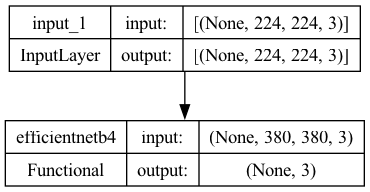

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

### Train the model

In [15]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=2, callbacks = [lr_scheduler,early_stopping])

Epoch 1/50


2024-02-25 17:14:03.582812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/165 - 193s - loss: 1.8227 - accuracy: 0.5650 - val_loss: 2.0440 - val_accuracy: 0.3333 - lr: 0.0010 - 193s/epoch - 1s/step
Epoch 2/50
165/165 - 171s - loss: 0.5232 - accuracy: 0.8206 - val_loss: 1.9514 - val_accuracy: 0.3333 - lr: 0.0010 - 171s/epoch - 1s/step
Epoch 3/50
165/165 - 164s - loss: 0.5144 - accuracy: 0.8267 - val_loss: 1.7773 - val_accuracy: 0.3333 - lr: 0.0010 - 164s/epoch - 995ms/step
Epoch 4/50
165/165 - 172s - loss: 0.4708 - accuracy: 0.8549 - val_loss: 1.2953 - val_accuracy: 0.5553 - lr: 9.0484e-04 - 172s/epoch - 1s/step
Epoch 5/50
165/165 - 166s - loss: 0.3270 - accuracy: 0.8847 - val_loss: 0.2613 - val_accuracy: 0.9114 - lr: 8.1873e-04 - 166s/epoch - 1s/step
Epoch 6/50
165/165 - 167s - loss: 0.2511 - accuracy: 0.9098 - val_loss: 0.1848 - val_accuracy: 0.9455 - lr: 7.4082e-04 - 167s/epoch - 1s/step
Epoch 7/50
165/165 - 164s - loss: 0.2431 - accuracy: 0.9136 - val_loss: 0.1942 - val_accuracy: 0.9523 - lr: 6.7032e-04 - 164s/epoch - 996ms/step
Epoch 8/50
165/165 - 16

### Train, Validation & Test accuracy from saved model

In [16]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

learning_rate = hist.history['lr']



### Plot Accuracy & Loss graphs

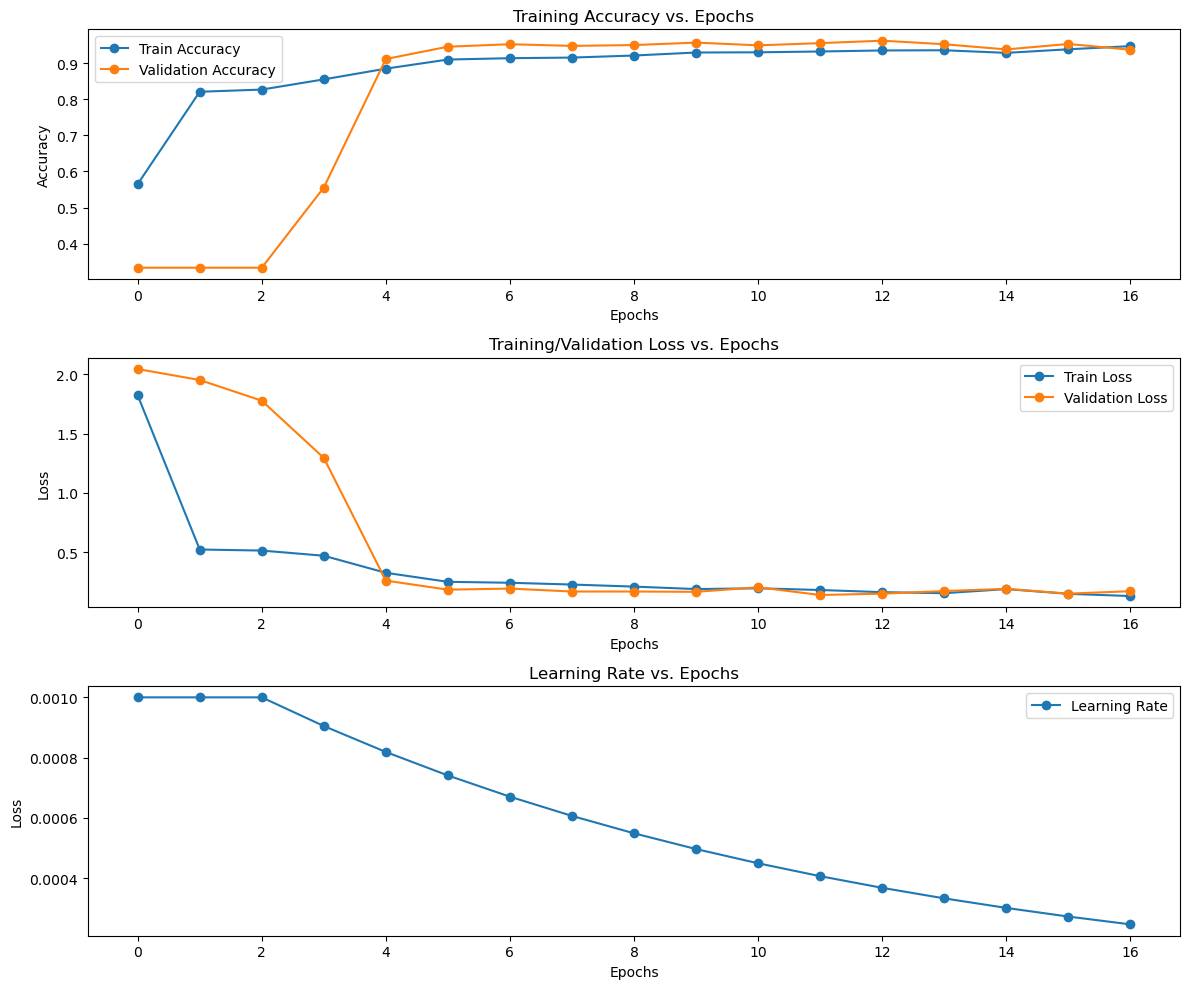

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### Predictions on Test data

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMAGE_SIZE),
                                                 class_mode='categorical')


Found 660 images belonging to 3 classes.


In [19]:


predictions = model.predict(test_generator)

21/21 [==============================] - 11s 384ms/step


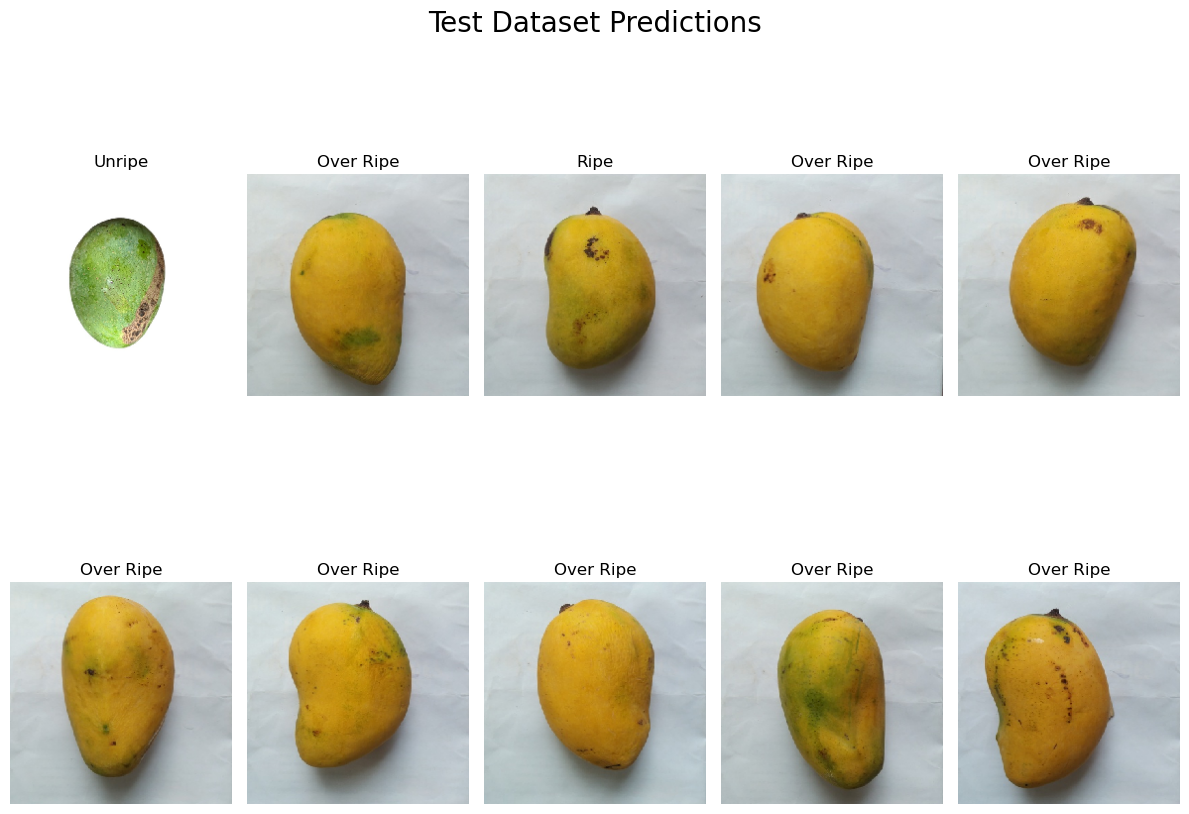

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

### F1- Score, Precision & Recall

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

21/21 [==============================] - 6s 284ms/step - loss: 0.1581 - accuracy: 0.9485


### Confusion Matrix

In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.15814803540706635
Test Accuracy: 0.9484848380088806


In [23]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

<Axes: >

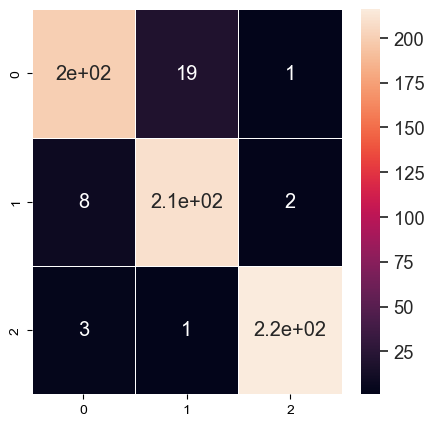

In [24]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   Over Ripe       0.95      0.91      0.93       220
        Ripe       0.91      0.95      0.93       220
      Unripe       0.99      0.98      0.98       220

    accuracy                           0.95       660
   macro avg       0.95      0.95      0.95       660
weighted avg       0.95      0.95      0.95       660



In [26]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [27]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

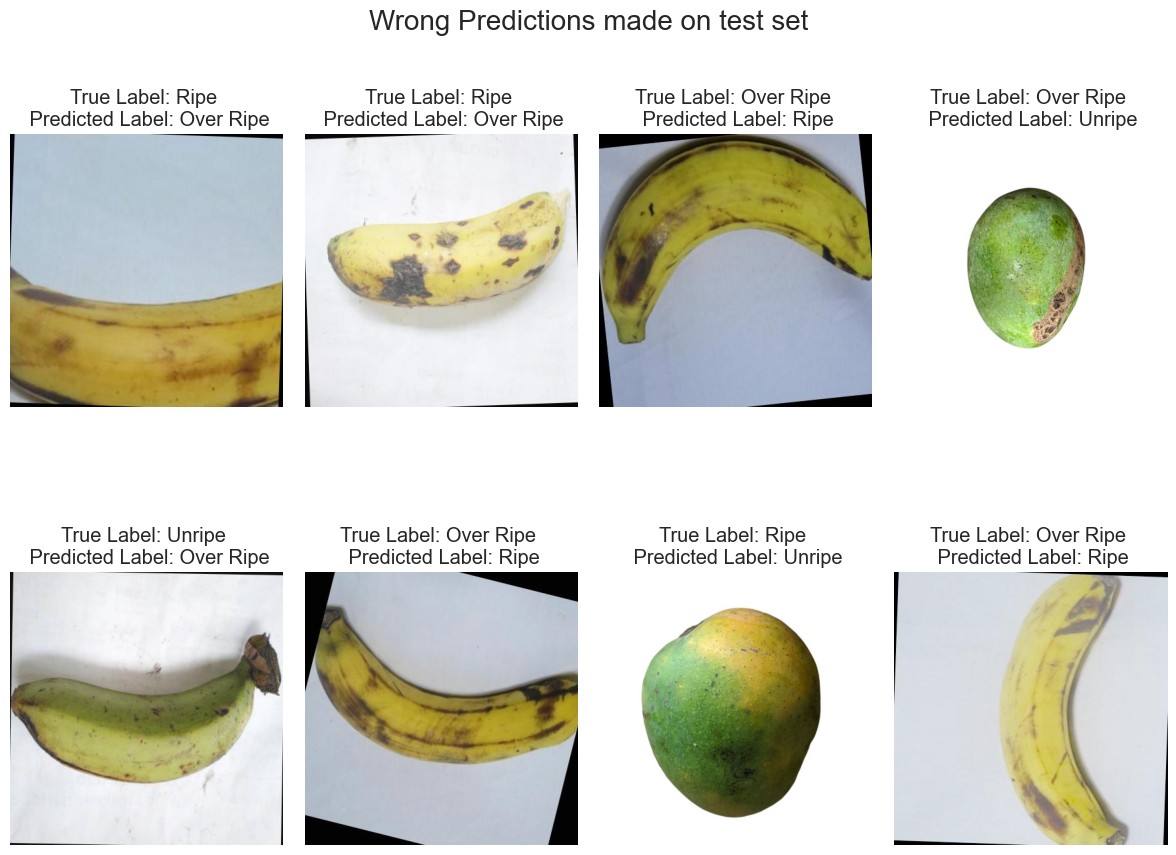

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(TEST_PATH, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()